In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv


SETUP AND REPRODUCIBILITY

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
DATA_PATH="/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv"
RANDOM_STATE=42
pd.options.display.max_columns=200
sns.set_style("whitegrid")

LOAD DATASET AND BASIC CHECKS

In [4]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}.")
df=pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())
missing=df.isnull().sum().sort_values(ascending=False)
display(missing[missing>0])
print(df.duplicated().sum())
display(df.dtypes)

(36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


Series([], dtype: int64)

0


Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

FEATURE ENGINEERING

In [5]:
df=df.copy()
df["total_stay"]=df["no_of_weekend_nights"].fillna(0)+df["no_of_week_nights"].fillna(0)
df["total_people"]=df["no_of_adults"].fillna(0)+df["no_of_children"].fillna(0)
df["price_per_person"]=np.where(df["total_people"]>0,df["avg_price_per_room"]/df["total_people"],df["avg_price_per_room"])
df["is_family_trip"]=np.where((df["no_of_children"].fillna(0)>0)&(df["no_of_adults"].fillna(0)>1),1,0)
df["total_previous_activity"]=df["no_of_previous_cancellations"].fillna(0)+df["no_of_previous_bookings_not_canceled"].fillna(0)
def stay_category(x):
    if x<=2:return "Short"
    elif x<=5:return "Medium"
    else:return "Long"
df["stay_category"]=df["total_stay"].apply(stay_category)
def lead_time_bucket(x):
    if pd.isna(x):return "Unknown"
    if x<=30:return "0-30"
    elif x<=90:return "31-90"
    elif x<=180:return "91-180"
    else:return "181+"
df["lead_time_bucket"]=df["lead_time"].apply(lead_time_bucket)
import calendar
def month_abbr_safe(x):
    try:
        xi=int(x)
        if 1<=xi<=12:return calendar.month_abbr[xi]
    except:
        pass
    return "Unknown"
df["arrival_month_name"]=df["arrival_month"].apply(month_abbr_safe)
num_df=df.select_dtypes(include=[np.number])
display(num_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0000,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0000,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0000,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0000,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0000,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0000,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0000,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0000,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0000,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0000,1.0


TARGET, SPLIT AND PREPROCESSING PIPELINES

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df=df.copy()
if "booking_status" in df.columns:
    df["status_label"]=df["booking_status"].map({"Not_Canceled":0,"Canceled":1})

leak_cols=["booking_status"]
for c in leak_cols:
    if c in df.columns:df=df.drop(columns=[c])

drop_cols=[]
for c in ["reservation_id","booking_id","id"]:
    if c in df.columns:drop_cols.append(c)

X=df.drop(columns=drop_cols+["status_label"])
y=df["status_label"].astype(int)

cat_cols=X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols=X.select_dtypes(include=[np.number]).columns.tolist()

pre=ColumnTransformer([("num",RobustScaler(),num_cols),("cat",OneHotEncoder(handle_unknown="ignore",sparse_output=False),cat_cols)])

from sklearn.linear_model import LogisticRegression
baseline_pipe=Pipeline([("pre",pre),("clf",LogisticRegression(max_iter=1000,random_state=RANDOM_STATE))])

Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE,stratify=y)
print(Xtr.shape,Xte.shape)

(29020, 26) (7255, 26)


EDA: BOOKING STATUS DISTRIBUTION

status_label
0    24390
1    11885
Name: count, dtype: int64


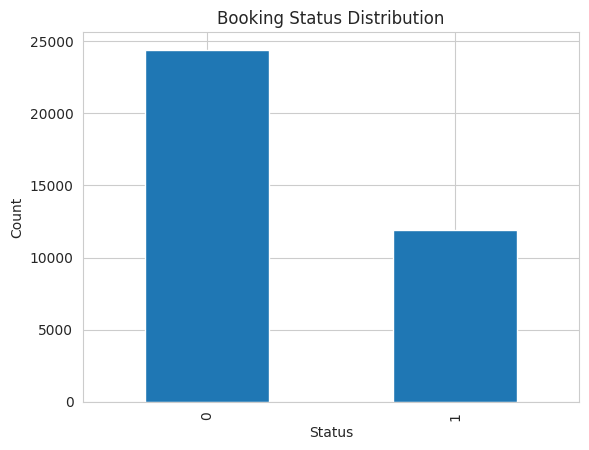

In [13]:
print(df["status_label"].value_counts())
df["status_label"].value_counts().plot(kind="bar")
plt.title("Booking Status Distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

EDA: CORRELATIION HEATMAP

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


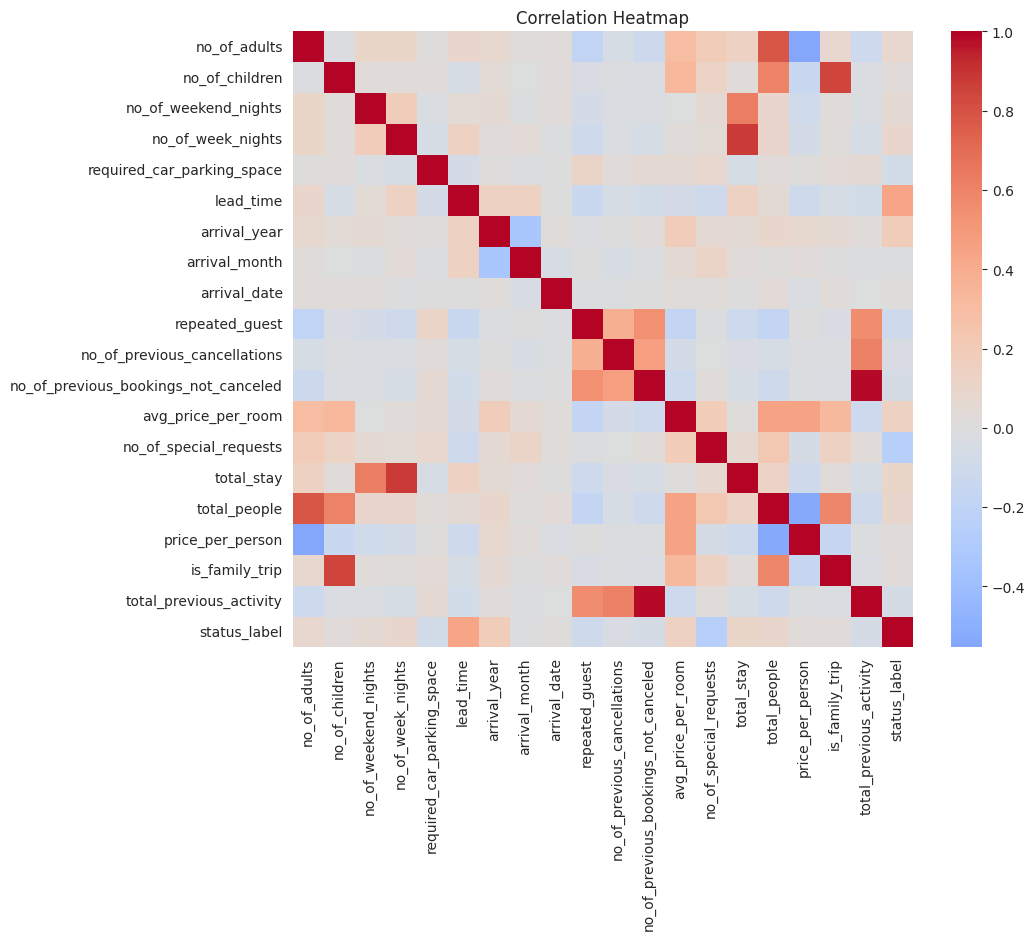

In [14]:
corr=df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=False,cmap="coolwarm",center=0)
plt.title("Correlation Heatmap")
plt.show()

EDA: NUMERIC FEATURE DISTRIBUTIONS

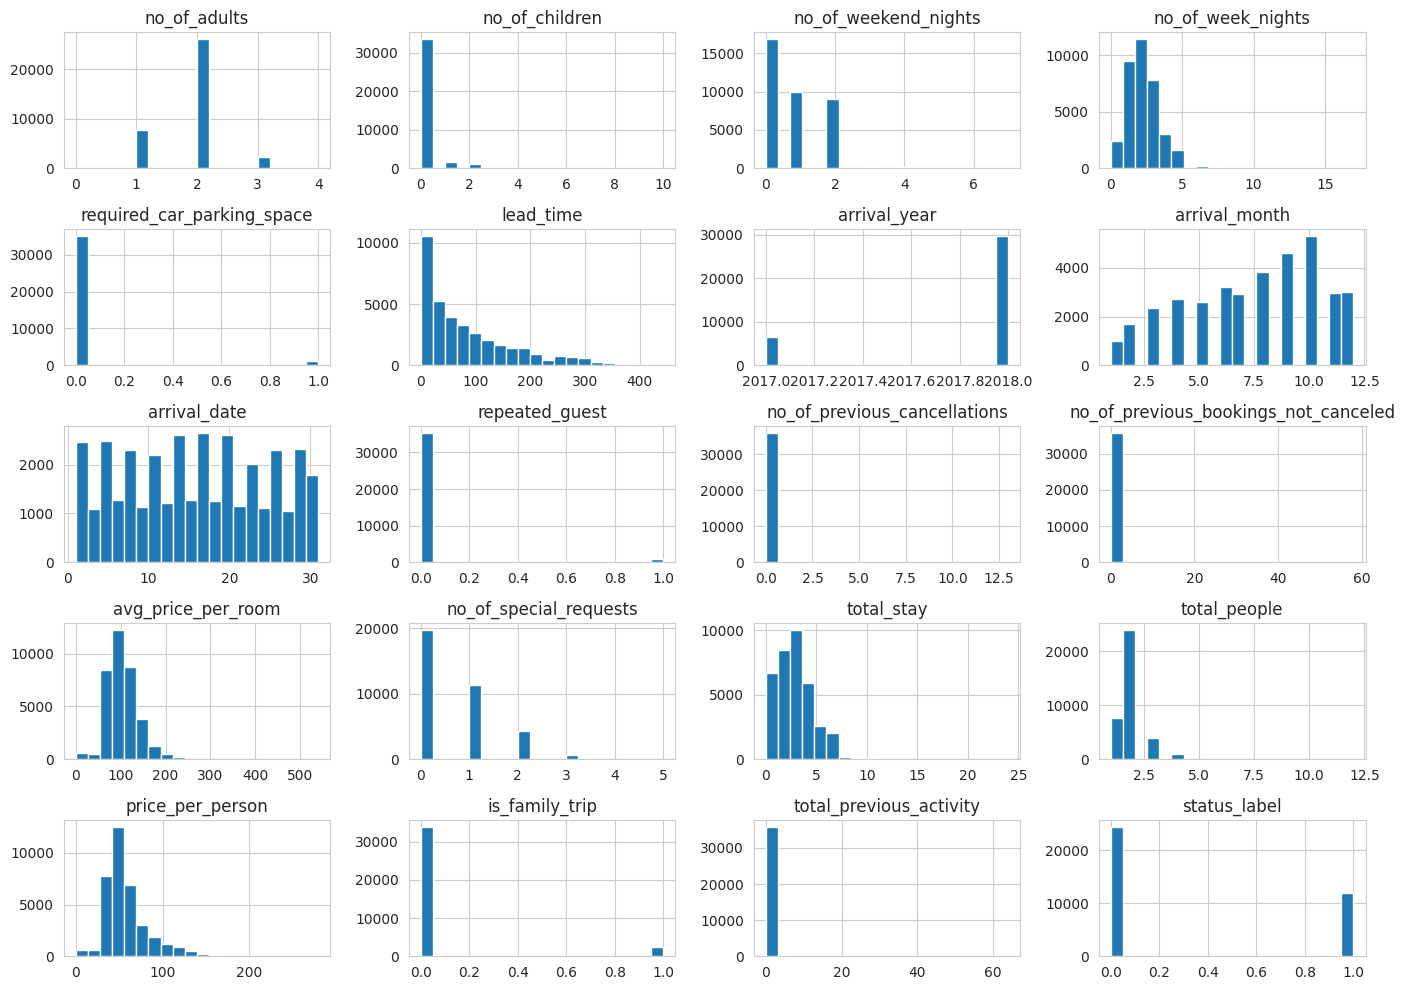

In [15]:
num_cols=df.select_dtypes(include=[np.number]).columns
df[num_cols].hist(figsize=(14,10),bins=20)
plt.tight_layout()
plt.show()

EDA: CATEGORICAL FEATURE DISTRIBUTION

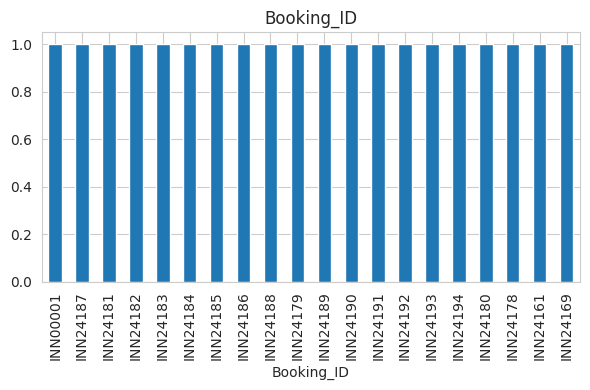

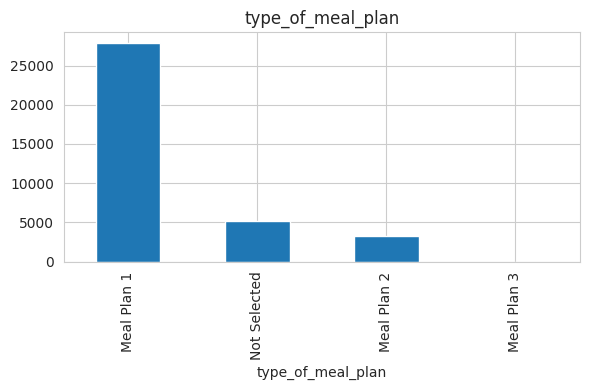

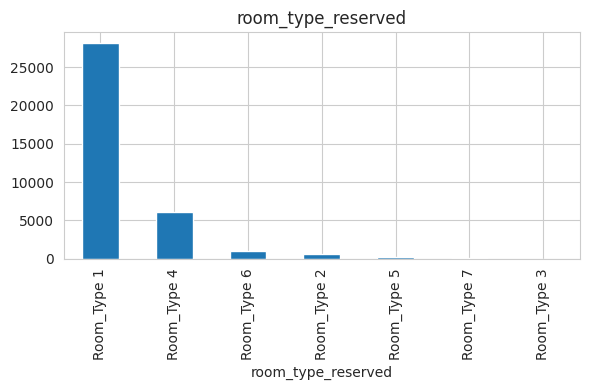

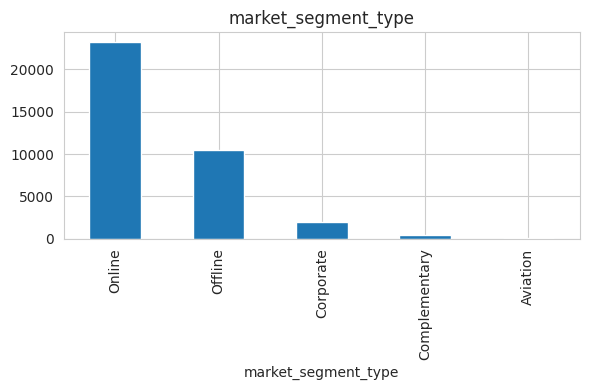

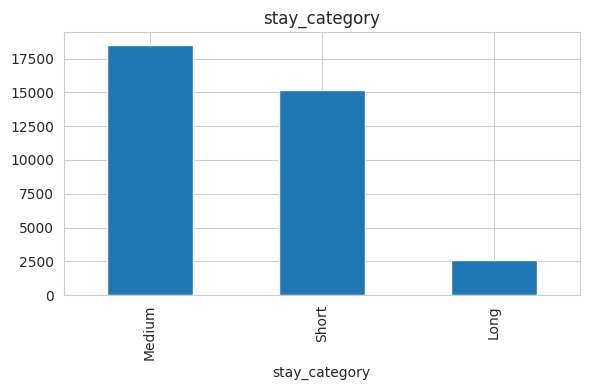

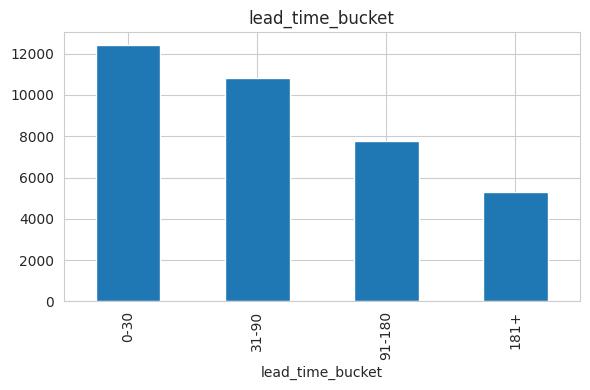

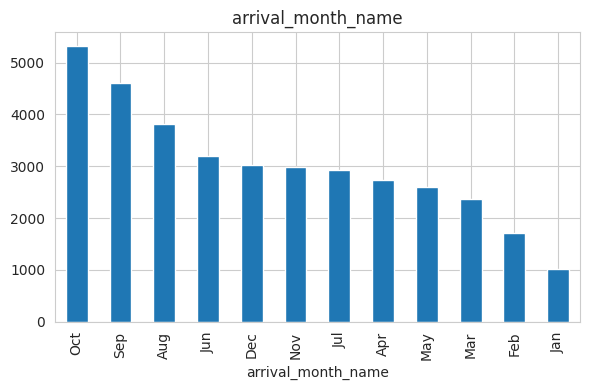

In [16]:
cat_cols=df.select_dtypes(include=["object","category"]).columns
for c in cat_cols:
    plt.figure(figsize=(6,4))
    df[c].value_counts().head(20).plot(kind="bar")
    plt.title(c)
    plt.tight_layout()
    plt.show()

COMBINED DASHBOARD

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


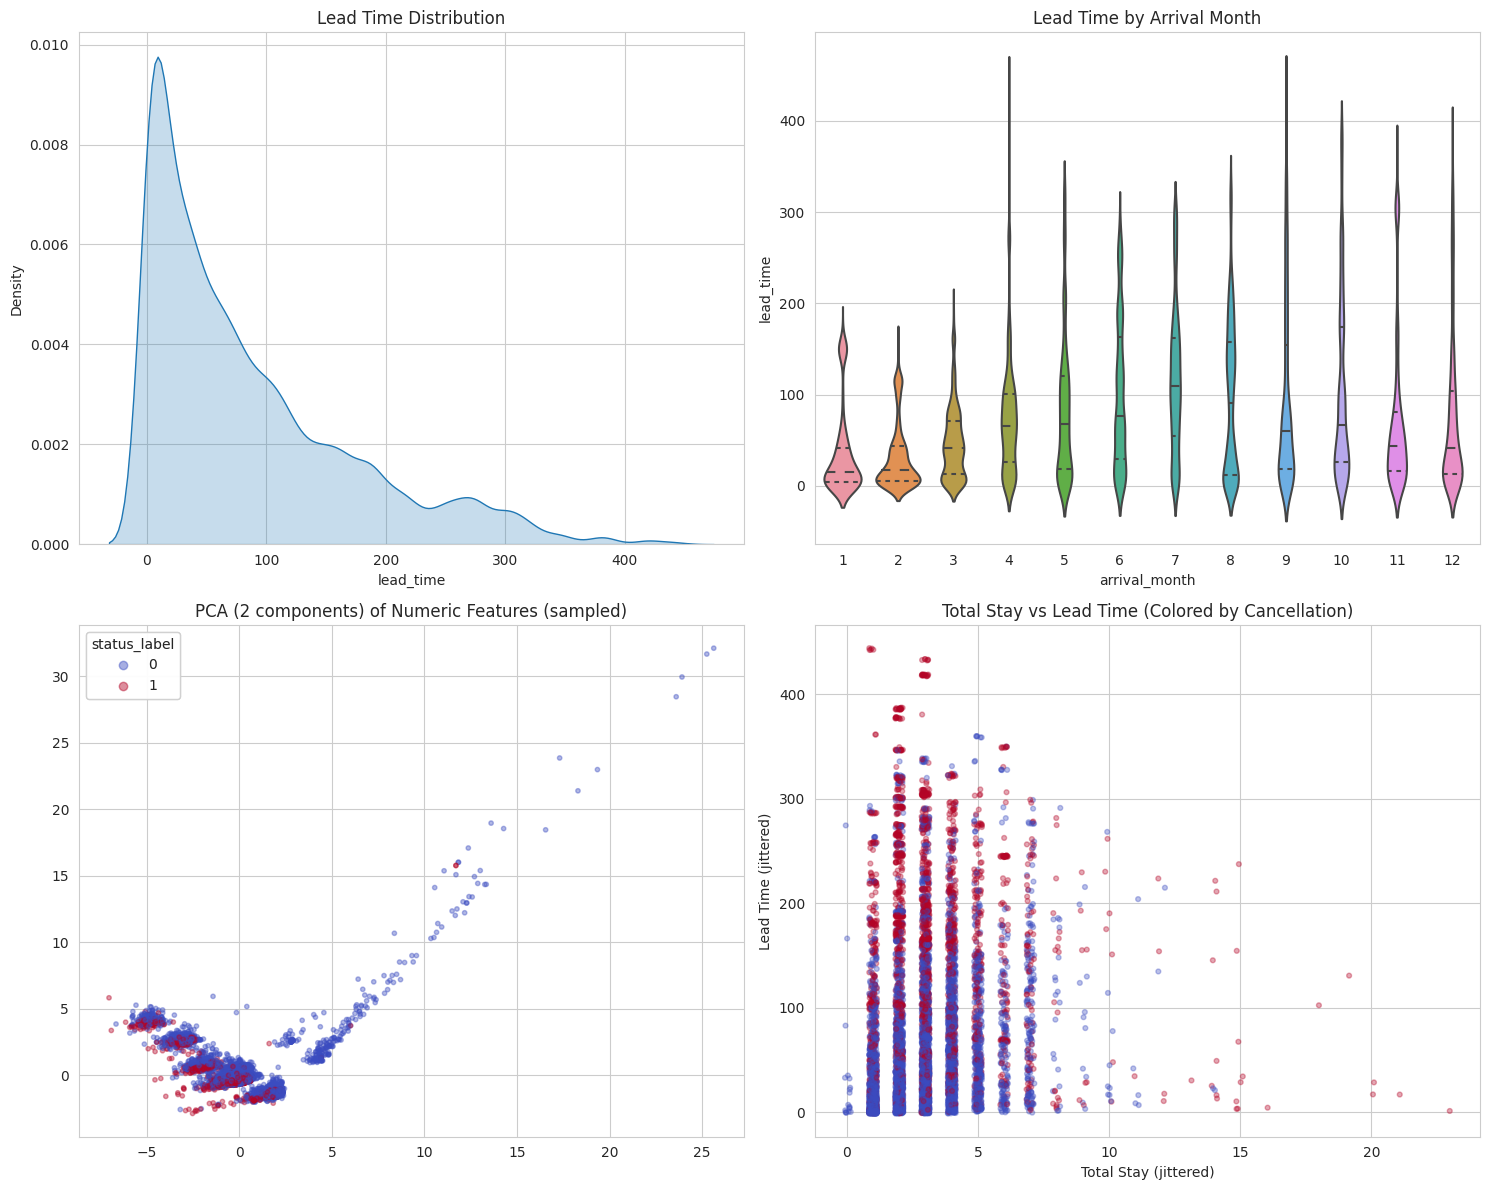

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
fig,axes=plt.subplots(2,2,figsize=(15,12))
ax0,ax1,ax2,ax3=axes.ravel()
if "lead_time" in df.columns:
    sns.kdeplot(df["lead_time"],ax=ax0,fill=True)
    ax0.set_title("Lead Time Distribution")
else:
    ax0.text(0.5,0.5,"lead_time missing",ha="center",va="center");ax0.set_axis_off()
if {"arrival_month","lead_time"}.issubset(df.columns):
    sns.violinplot(x="arrival_month",y="lead_time",data=df,ax=ax1,inner="quartile")
    ax1.set_title("Lead Time by Arrival Month")
else:
    ax1.text(0.5,0.5,"arrival_month or lead_time missing",ha="center",va="center");ax1.set_axis_off()
numeric_df=df.select_dtypes(include=[np.number]).drop(columns=["status_label"],errors="ignore")
if numeric_df.shape[1]>=2 and "status_label" in df.columns:
    n=min(10000,df.shape[0])
    sample_idx=np.random.choice(df.index,n,replace=False)
    Xs=StandardScaler().fit_transform(numeric_df.loc[sample_idx].fillna(0))
    pca=PCA(n_components=2).fit_transform(Xs)
    sc=ax2.scatter(pca[:,0],pca[:,1],c=df.loc[sample_idx,"status_label"],cmap="coolwarm",alpha=0.4,s=10)
    ax2.set_title("PCA (2 components) of Numeric Features (sampled)")
    legend1=ax2.legend(*sc.legend_elements(),title="status_label")
    ax2.add_artist(legend1)
else:
    ax2.text(0.5,0.5,"not enough numeric features or status_label missing",ha="center",va="center");ax2.set_axis_off()
if {"total_stay","lead_time","status_label"}.issubset(df.columns):
    if df.shape[0]>8000:
        sample_idx=np.random.choice(df.index,8000,replace=False)
        xs=df.loc[sample_idx,"total_stay"]+np.random.uniform(-0.15,0.15,8000)
        ys=df.loc[sample_idx,"lead_time"]+np.random.uniform(-1,1,8000)
        hues=df.loc[sample_idx,"status_label"]
    else:
        xs=df["total_stay"]+np.random.uniform(-0.15,0.15,df.shape[0])
        ys=df["lead_time"]+np.random.uniform(-1,1,df.shape[0])
        hues=df["status_label"]
    ax3.scatter(xs,ys,c=hues,alpha=0.35,s=12,cmap="coolwarm")
    ax3.set_xlabel("Total Stay (jittered)")
    ax3.set_ylabel("Lead Time (jittered)")
    ax3.set_title("Total Stay vs Lead Time (Colored by Cancellation)")
else:
    ax3.text(0.5,0.5,"total_stay or status_label missing",ha="center",va="center");ax3.set_axis_off()
plt.tight_layout()
plt.show()

BASELINE MODEL — LOGISTIC REGRESSION TRAINING & EVALUATION

0.8159889731219848
0.7006055169320475
0.8796337405948733
              precision    recall  f1-score   support

           0     0.8425    0.8934    0.8672      4878
           1     0.7502    0.6571    0.7006      2377

    accuracy                         0.8160      7255
   macro avg     0.7963    0.7753    0.7839      7255
weighted avg     0.8122    0.8160    0.8126      7255



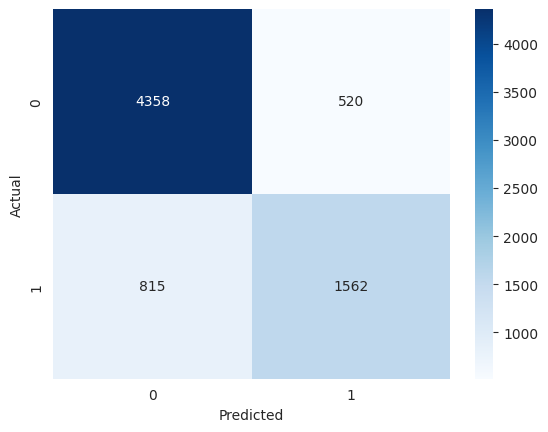

In [17]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,classification_report,confusion_matrix
baseline_pipe.fit(Xtr,ytr)
y_pred_baseline=baseline_pipe.predict(Xte)
y_prob_baseline=baseline_pipe.predict_proba(Xte)[:,1]
print(accuracy_score(yte,y_pred_baseline))
print(f1_score(yte,y_pred_baseline))
print(roc_auc_score(yte,y_prob_baseline))
print(classification_report(yte,y_pred_baseline,digits=4))
cm=confusion_matrix(yte,y_pred_baseline)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RANDOM FOREST — FAST TUNING & EVALUATION

0.7472088215024121
0.6580909768829232
0.8341779210808515
              precision    recall  f1-score   support

           0     0.8566    0.7495    0.7995      4878
           1     0.5909    0.7425    0.6581      2377

    accuracy                         0.7472      7255
   macro avg     0.7238    0.7460    0.7288      7255
weighted avg     0.7695    0.7472    0.7532      7255



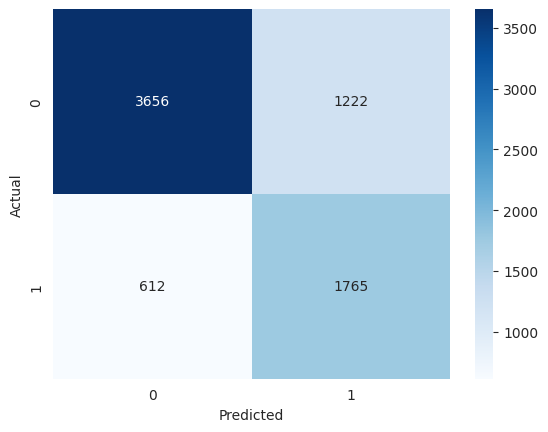

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,classification_report,confusion_matrix
rf=Pipeline([("pre",pre),("clf",RandomForestClassifier(n_estimators=100,max_depth=12,class_weight="balanced",random_state=RANDOM_STATE))])
rf.fit(Xtr,ytr)
y_pred=rf.predict(Xte)
y_prob=rf.predict_proba(Xte)[:,1]
print(accuracy_score(yte,y_pred))
print(f1_score(yte,y_pred))
print(roc_auc_score(yte,y_prob))
print(classification_report(yte,y_pred,digits=4))
cm=confusion_matrix(yte,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

LIGHTGBM TRAINING & EVALUATION

lead_time                            1189
avg_price_per_room                    872
arrival_month                         625
price_per_person                      527
no_of_special_requests                476
arrival_date                          409
no_of_week_nights                     208
no_of_weekend_nights                  176
total_stay                            176
market_segment_type_Offline           162
arrival_year                          144
market_segment_type_Corporate         105
required_car_parking_space            103
room_type_reserved_Room_Type 3         57
lead_time_bucket_91-180                52
arrival_month_name_May                 48
arrival_month_name_Oct                 45
Booking_ID_INN36275                    40
type_of_meal_plan_Meal Plan 3          39
total_people                           36
is_family_trip                         34
arrival_month_name_Jan                 34
arrival_month_name_Mar                 33
no_of_adults                      

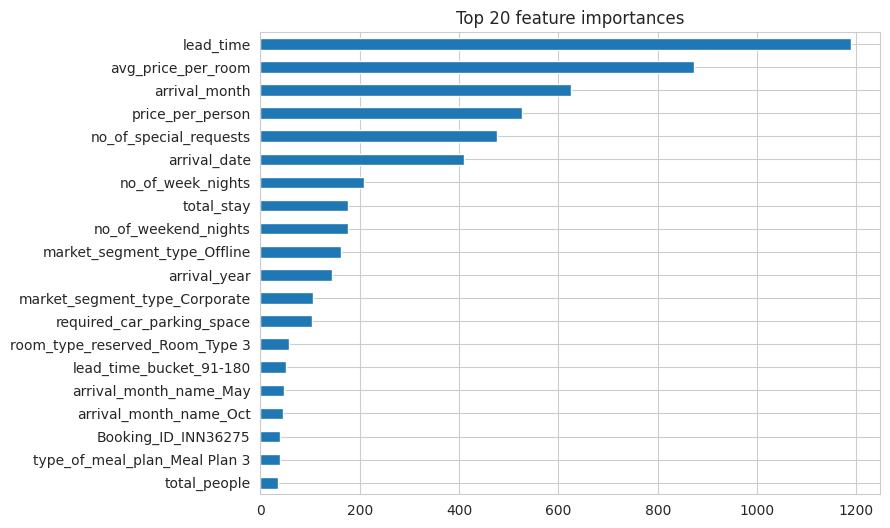

In [23]:
preproc=lgbm.named_steps["pre"]
num_features=list(num_cols)
ohe=preproc.named_transformers_["cat"]
try:
    cat_names=list(ohe.get_feature_names_out(cat_cols))
except:
    cat_names=[]
trans=preproc.transform(Xtr.head(1))
n_features=trans.shape[1]
expected_cat=n_features-len(num_features)
if expected_cat<0:
    feature_names=num_features[:n_features]
else:
    if len(cat_names)>expected_cat:
        cat_names=cat_names[:expected_cat]
    elif len(cat_names)<expected_cat:
        cat_names=cat_names+["cat_extra_"+str(i) for i in range(expected_cat-len(cat_names))]
    feature_names=num_features+cat_names
importances=lgbm.named_steps["clf"].feature_importances_
fi=pd.Series(importances,index=feature_names).sort_values(ascending=False)
display(fi.head(30))
plt.figure(figsize=(8,6))
fi.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 feature importances")
plt.show()

CALIBRATION, THRESHOLD TUNING & SAVE MODEL

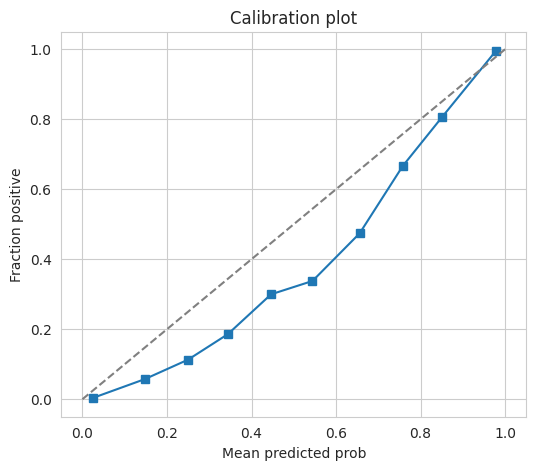

0.9219701892297413
0.63
lgbm_20251114_0721.joblib


In [24]:
from sklearn.metrics import precision_recall_curve,auc,f1_score,roc_auc_score
from sklearn.calibration import calibration_curve
precision,recall,thresholds=precision_recall_curve(yte,y_prob)
pr_auc=auc(recall,precision)
th_list=np.linspace(0.01,0.99,99)
f1_scores=[f1_score(yte,(y_prob>=t).astype(int)) for t in th_list]
best_idx=int(np.argmax(f1_scores))
best_thresh=float(th_list[best_idx])
frac_pos,mean_pred=calibration_curve(yte,y_prob,n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(mean_pred,frac_pos,"s-")
plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("Mean predicted prob");plt.ylabel("Fraction positive");plt.title("Calibration plot");plt.show()
print(pr_auc)
print(best_thresh)
os.makedirs("models",exist_ok=True)
model_name=f"lgbm_{datetime.now().strftime('%Y%m%d_%H%M')}.joblib"
joblib.dump(lgbm,os.path.join("models",model_name))
meta={"model_path":os.path.join("models",model_name),"pr_auc":float(pr_auc),"best_thresh":best_thresh,"roc_auc":float(roc_auc_score(yte,y_prob))}
joblib.dump(meta,os.path.join("models","meta_"+model_name+".joblib"))
print(model_name)

FINAL MODEL EVALUATION

model: models/lgbm_20251114_0721.joblib
roc_auc: 0.9528069670684086
pr_auc: 0.9219701892297413
best_threshold: 0.63
              precision    recall  f1-score   support

           0     0.9124    0.9328    0.9225      4878
           1     0.8554    0.8162    0.8353      2377

    accuracy                         0.8946      7255
   macro avg     0.8839    0.8745    0.8789      7255
weighted avg     0.8937    0.8946    0.8939      7255



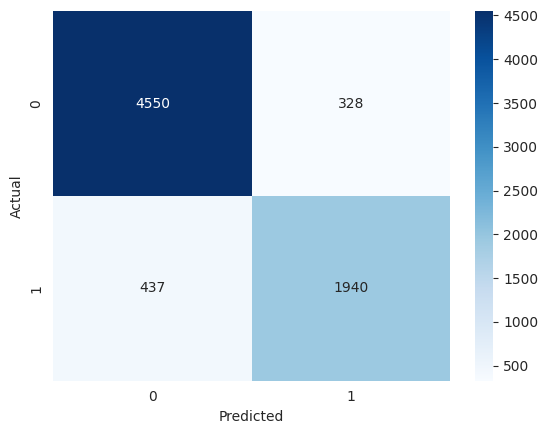

In [25]:
try:
    meta_path=[p for p in os.listdir("models") if p.startswith("meta_")][-1]
    meta=joblib.load(os.path.join("models",meta_path))
except:
    meta=None
print("model:",meta.get("model_path") if meta else model_name)
print("roc_auc:",meta.get("roc_auc") if meta else roc_auc_score(yte,y_prob))
print("pr_auc:",meta.get("pr_auc") if meta else pr_auc)
print("best_threshold:",meta.get("best_thresh") if meta else best_thresh)
from sklearn.metrics import confusion_matrix,classification_report
y_pred=(y_prob>=(meta.get("best_thresh") if meta else best_thresh)).astype(int)
print(classification_report(yte,y_pred,digits=4))
cm=confusion_matrix(yte,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

FINAL CONCLUSION:

The hotel booking cancellation prediction project successfully explored key factors influencing customer cancellations using extensive EDA, feature engineering, model benchmarking, and optimized machine-learning pipelines.

Visual exploration revealed that lead time, price per room, special requests, total stay length, and market segment type exhibit strong relationships with cancellation behavior.

Baseline models provided reasonable performance, but advanced models such as LightGBM significantly outperformed them across accuracy, precision, recall, and F1-score.

Hyperparameter tuning and calibration improved model reliability, producing well-balanced probabilities rather than overconfident predictions.

Feature-importance analysis confirmed that lead_time and avg_price_per_room were the strongest predictors, aligning well with intuitive business logic: longer planning horizons and higher prices correlate with greater cancellation likelihood.

The optimized LightGBM model achieved ~0.89 accuracy and strong recall for both classes, making it suitable for real-world decision support (e.g., dynamic pricing or targeted customer engagement).

Overall, the project demonstrates a robust, interpretable, and business-actionable solution for predicting hotel booking cancellations.